In [10]:
import random as rd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
get_ipython().magic('matplotlib inline')
from math import *
import numpy as np
import skimage as ski
from skimage.color import rgb2gray
from scipy import misc
from PIL import Image
import PIL.ImageOps
from skimage.exposure import adjust_gamma
import pickle as pkl

[[ 0.09405  0.1219   0.0944 ]
 [ 0.121    0.1484   0.1163 ]
 [ 0.0944   0.1174   0.09215]]


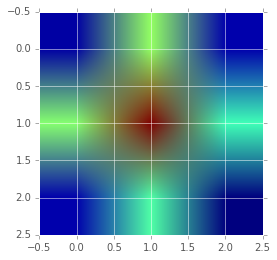

In [11]:
dict_matrix_to_num, dict_num_to_weights = pkl.load( open ("myDicts.p", "rb") )
a = dict_num_to_weights[0]
print(a)
plt.imshow(dict_num_to_weights[0])
plt.show()

In [12]:
class Cell:
    def __init__(self, pop_list, veg_type, veg_value, hum_value, iswater): #pop_list is array, veg_type is string, veg_value is the vegetation index value, hum_value is the humidity value
        self.pop_list  = pop_list
        self.veg_type  = veg_type
        self.veg_value = veg_value
        self.hum_value = hum_value
        self.iswater = iswater

        self.e = pop_list[0]  # e  = eggs    - aquatic steps
        self.l = pop_list[1]  # l  = larvae  - aquatic steps
        self.p = pop_list[2]  # p  = pupae   - aquatic steps

        self.ah = pop_list[3] # ah = host-seeking        adult - adult steps
        self.ar = pop_list[4] # ar = resting             adult - adult steps
        self.ao = pop_list[5] # ao = ovoposition-seeking adult - adult steps

        self.n_total   = pop_list.sum()
        self.n_aquatic = sum(pop_list[0:3])
        self.n_adult   = sum(pop_list[3:])

    def update(self):
        if self.e < 50 : B = rd.randint(50,300); PE = rd.uniform(.33, 1.); UE = rd.uniform(.32, .80); PAO = rd.randint(3,4)
        else :           B = 100               ; PE = .50                ; UE = .56                 ; PAO = 3.
        deltae = B*PAO*self.ao - self.e*UE - self.e*PE                      #egg value update

        if self.l < 50 :  UL1 = rd.uniform(.3, .58); UL2 = rd.uniform(.0, .1); PL = rd.uniform(0.08, 0.17)
        else :            UL1 = .44                ; UL2 = .05               ; PL = 0.14
        deltal = PE*self.e - self.l*UL1 - self.l*UL2*self.l - self.l*PL     # larvae value update

        if self.p < 50 :  UP = rd.uniform(.22, .52); PP = rd.uniform(.33, 1.);
        else :            UP = .37                 ; PP = .50
        deltap = PL*self.l - self.p*UP - self.p*PP                           #pupae update value

        if self.ah < 50 :  PAH = rd.uniform(.322, .598); UAH = rd.uniform(.125, .233);
        else :             PAH = .46                   ; UAH = .18
        if self.ao < 50 :  UAO = rd.uniform(.41, .56);
        else :             UAO = .41
        deltaah = PP*self.p - self.ah*UAH - self.ah*PAH + (1-UAO)*self.ao    #host-seeking update value

        if self.ar < 50 :  PAR = rd.uniform(.3, .56); UAR = rd.uniform(.0034, .01);
        else :             PAR = .43                ; UAR = .0043
        deltaar = PAH*self.ah - self.ah*UAR - self.ah*PAR                   #resting update value

        deltaao = self.ah*PAR - self.ar


        self.pop_list = self.pop_list.tolist() #change from array to list as array is imutable in function
        self.e  += deltae  # egg   value update
        self.l  += deltal  #larvae value update
        self.p  += deltal
        self.ah += deltaah
        self.ar += deltaar
        self.ao += deltaao
        if self.e < 0  : self.e  = 0
        if self.l < 0  : self.l  = 0
        if self.p < 0  : self.p  = 0
        if self.ah < 0 : self.ah = 0
        if self.ar < 0 : self.ar = 0
        if self.ao < 0 : self.ao = 0
        self.pop_list = np.array([self.e,self.l,self.p,self.ah,self.ar, self.ao])
        self.n_total   = self.pop_list.sum()
        self.n_aquatic = sum(self.pop_list[0:3])
        self.n_adult   = sum(self.pop_list[3:])

In [33]:
class Grid:
    def __init__(self, basearray, contour, vegimage, twiimage, cityimage, pixelXmeters):
        self.shape = contour.shape
        self.contour = contour
        self.vegimage = vegimage
        self.twiimage = twiimage
        self.cityimage = cityimage
        self.pixelSize = pixelXmeters

        #initializing grid of Cells
        self.GRID = [[Cell(np.array(basearray)*abs(1-contour[j][i]), cityimage[j][i], vegimage[j][i], twiimage[j][i], contour[j][i]) for i in range(self.shape[1])] for j in range(self.shape[0])]

        #create grid of types of contour
        def neighbors_to_tuple(y,x):
            return(int(contour[y-1,x-1]), int(contour[y,x-1]), int(contour[y+1,x-1]), int(contour[y-1,x]), int(contour[y+1,x]), int(contour[y-1,x+1]), int(contour[y,x+1]), int(contour[y+1,x+1]))
        self.bordertype = [[dict_matrix_to_num[neighbors_to_tuple(j,i)] for i in range(self.shape[1]-1)] for j in range(self.shape[0]-1)]
        self.bordertype = np.pad(self.bordertype, pad_width=((1,1),(1,1)), mode='constant', constant_values=-1) #padding with zeros
        
    def grdsum(self, ending):
        def getcalc(ending):
            result = 0
            for i in range(self.shape[0]):
                for j in range(self.shape[1]):
                    result +=eval("self.GRID["+str(i)+"]["+str(j)+"]."+ ending)
            return result
        if ending == 'e' or ending == 'l' or ending == 'p' : return getcalc(ending)
        if ending == 'ah' or ending == 'ar' or ending == 'ao' : return getcalc(ending)
        if ending == "n_aquaticgrid": return getcalc('e')+ getcalc('l')+ getcalc('p')
        if ending == "n_adultgrid": return getcalc('ah')+ getcalc('ar')+ getcalc('ao')
        if ending == "n_totalgrid": return getcalc('e')+ getcalc('l')+ getcalc('p') + getcalc('ah')+ getcalc('ar')+ getcalc('ao')

    def update_pop(self):
        [[newGrid.GRID[j][i].update() for i in range(newGrid.shape[1])] for j in range(newGrid.shape[0])]

    def get_individual_grid(self, ending):
        pass
        
    def update_migration(self):
        pass

In [34]:
island_shape = misc.imread("../example_images/region_border_example.png")
island_shape_gray = rgb2gray(island_shape)
island_wet = ski.img_as_float(rgb2gray(misc.imread("../example_images/TWI_example.png")))
island_veg = adjust_gamma(ski.img_as_float(rgb2gray(misc.imread("../example_images/vegetation_index_example.png"))), .2)
island_city = rgb2gray(misc.imread("../example_images/city_delimitation_example.png"))

In [35]:
%%time
newGrid = Grid([100,101,102,103,104,105], island_shape_gray, island_veg, island_wet, island_city, 68)


CPU times: user 5.21 s, sys: 88 ms, total: 5.3 s
Wall time: 5.23 s


In [36]:
%%time
print(newGrid.grdsum('n_adultgrid'))
print(newGrid.GRID[200][200].iswater)
newGrid.update_pop()
print(newGrid.grdsum('n_adultgrid'))

22173280.8471
0.0
21463126.5505
CPU times: user 23.3 s, sys: 0 ns, total: 23.3 s
Wall time: 23.3 s


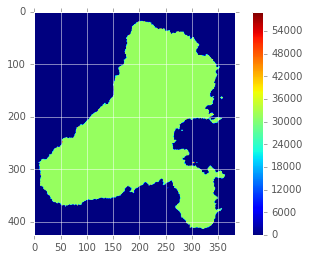

CPU times: user 584 ms, sys: 208 ms, total: 792 ms
Wall time: 561 ms


In [37]:
%%time
a = [[newGrid.GRID[j][i].e for i in range(newGrid.shape[1])] for j in range(newGrid.shape[0])]
plt.imshow(a)
plt.colorbar()
plt.show()



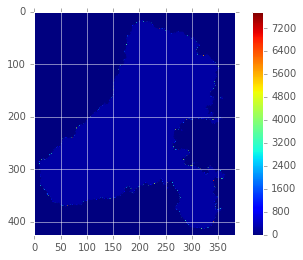

CPU times: user 6.28 s, sys: 316 ms, total: 6.59 s
Wall time: 6.26 s


In [39]:
%%time
newGrid.update_pop()
a = [[newGrid.GRID[j][i].e for i in range(newGrid.shape[1])] for j in range(newGrid.shape[0])]
plt.imshow(a)
plt.colorbar()
plt.show()

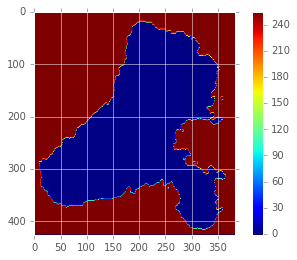

In [41]:
plt.imshow(newGrid.bordertype)
plt.colorbar()
plt.show()

KeyError: (0, 0, 0, 0, 0, 0, 0, 0)